In [1]:
import tqdm
import itertools
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from zeo_amd.cluster import get_positive_clusters, homogeneity_score, recall_homogeneity

plt.style.use("jupyter")

In [2]:
dm = pd.read_csv("../data/iza_dm.csv", index_col=0)
synth = pd.read_csv("../data/synthesis_fraction.csv", index_col=0)
synth = synth.loc[dm.index]

LABELS = ['Al', 'B', 'Be', 'Ca', 'Co', 'F', 'Ga', 'Ge', 'K', 'Mg', 'Na', 'P', 'Si', 'Zn']

In [3]:
Z = linkage(squareform(dm.values), method='ward')

## Quantifying degree of clustering

In [4]:
SYN_THRESHOLD = 0.25
THRESHOLDS = np.concatenate([
    np.arange(0.1, 1, 0.01),
    np.arange(1, 3.5, 0.1),
])
    
results = []
for threshold in tqdm.tqdm_notebook(THRESHOLDS):
    clusters = fcluster(Z, threshold, criterion='distance')
    
    for condition in synth.columns:
        labels = (synth[condition] > SYN_THRESHOLD).astype(int)

        _l, _c = get_positive_clusters(labels.values, clusters)
        
        results.append({
            "threshold": threshold,
#             condition: recall_homogeneity(labels.values, clusters),
            condition: homogeneity_score(_l, _c)
        })

df = pd.DataFrame(results)
df = df.groupby("threshold").first()

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_77269/1177137434.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for threshold in tqdm.tqdm_notebook(THRESHOLDS):


  0%|          | 0/115 [00:00<?, ?it/s]

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


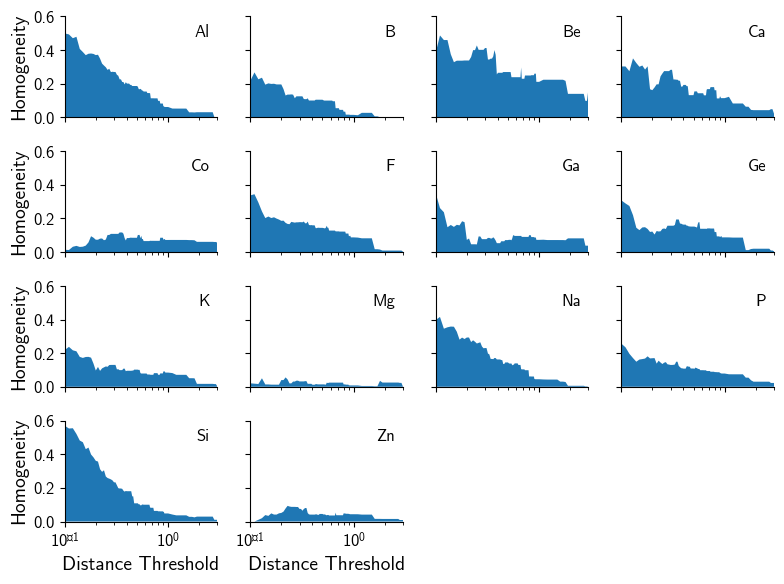

In [5]:
LX, LY = 2, 1.5
fig, ax_fig = plt.subplots(4, 4, figsize=(4 * LX, 4 * LY), sharex=True, sharey=True)

for ax, label in zip(ax_fig.reshape(-1), LABELS):
    ax.fill_between(
        df.index,
        df[label],
        label=label,
    )
    ax.set_xlim(0.1, 3)
    ax.set_ylim(0, 0.6)
    ax.set_xscale("log")
    ax.annotate(label, (0.95, 0.85), xycoords='axes fraction', ha="right", va="center")

for ax in ax_fig[-1, :]:
    ax.set_xlabel("Distance Threshold")

for ax in ax_fig[:, 0]:
    ax.set_ylabel("Homogeneity")

for ax in ax_fig.reshape(-1)[-2:]:
    ax.axis("off")

fig.tight_layout()
plt.show()

## Highlighting the graph based on the synthesis conditions

With the minimum spanning tree obtained in a previous notebook, we show how different synthesis conditions are illustrated in the graph.

In [6]:
with open("../data/iza_mst_nx.pkl", "rb") as f:
    G = pickle.load(f)

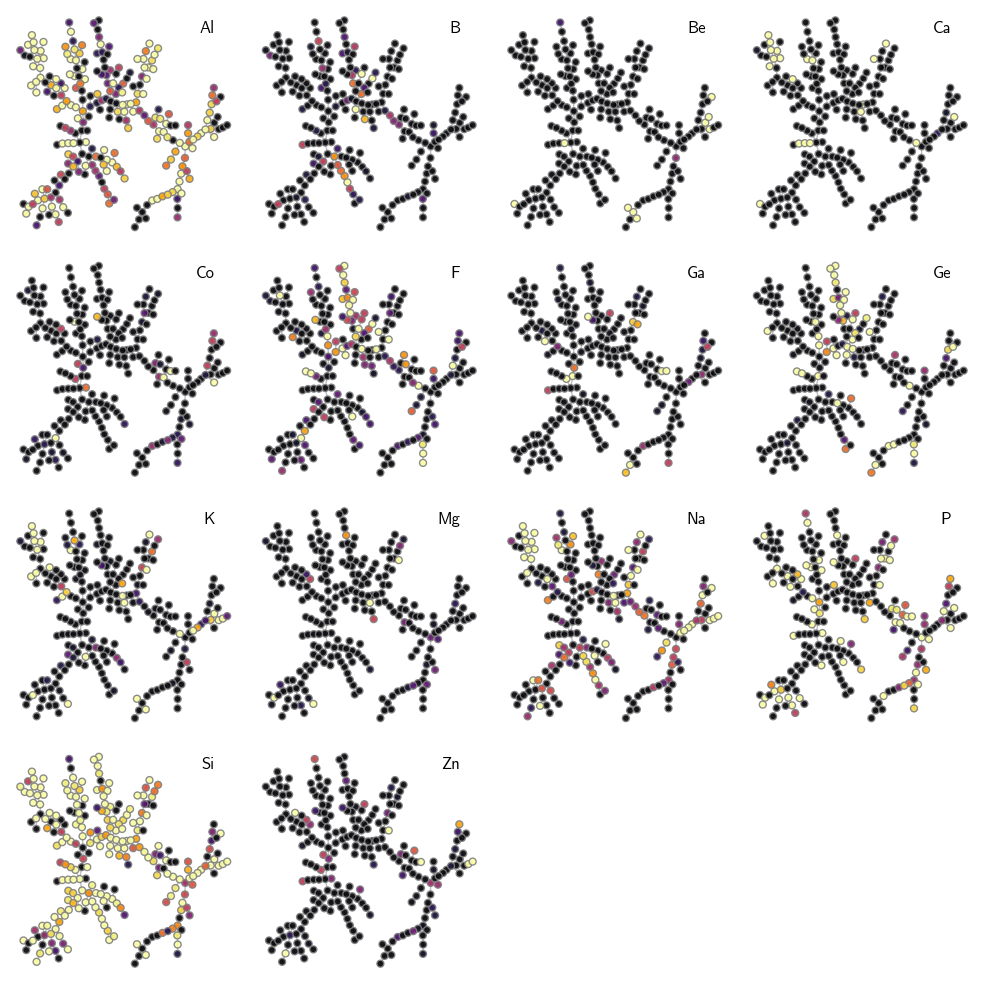

In [ ]:
L = 2.5
fig, ax_fig = plt.subplots(4, 4, figsize=(4 * L, 4 * L))

pos = nx.get_node_attributes(G, "pos")

options = {
    "edgecolors": "tab:gray",
    "node_size": 25,
    "alpha": 0.9,
    "cmap": "inferno",
    "vmin": 0,
    "vmax": 1,
}

for ax, label in zip(ax_fig.reshape(-1), LABELS):
    nx.draw_networkx_nodes(G, pos, node_color=synth[label], ax=ax, **options)

    for i, j in G.edges:
        xy = np.stack([pos[i], pos[j]])
        ax.plot(xy[:, 0], xy[:, 1], linewidth=1.0, color="#808080", alpha=0.5, zorder=-1)
    
    ax.axis("off")
    ax.annotate(label, (0.9, 0.9), xycoords="axes fraction", ha="right", fontsize=12)

for ax in ax_fig.reshape(-1)[-2:]:
    ax.axis("off")
    
plt.tight_layout()
# fig.savefig("iza-tmap.pdf", bbox_inches="tight", transparent=True)
plt.show()

## Hierarchical clustering

Using the distance matrix obtained with the AMD, we perform a hierarchical clustering and analyze the data using a dendrogram

In [ ]:
clusters = fcluster(Z, 1, criterion="distance")

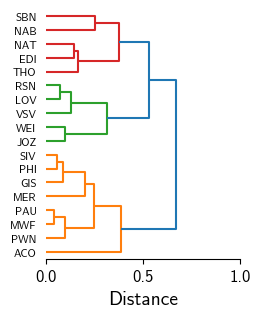

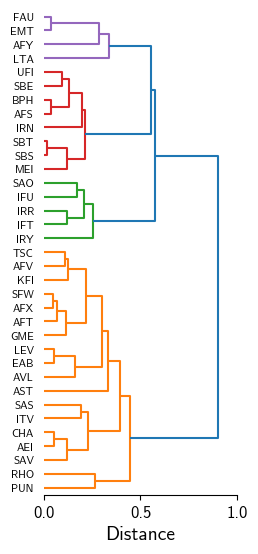

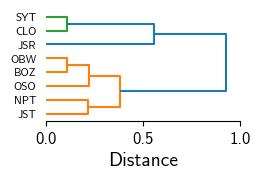

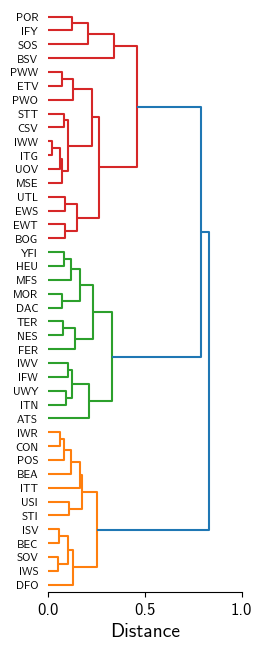

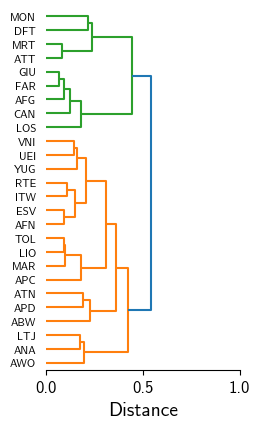

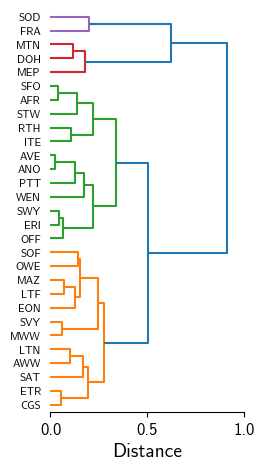

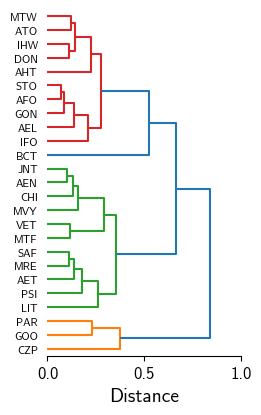

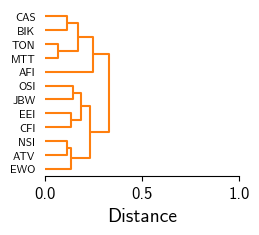

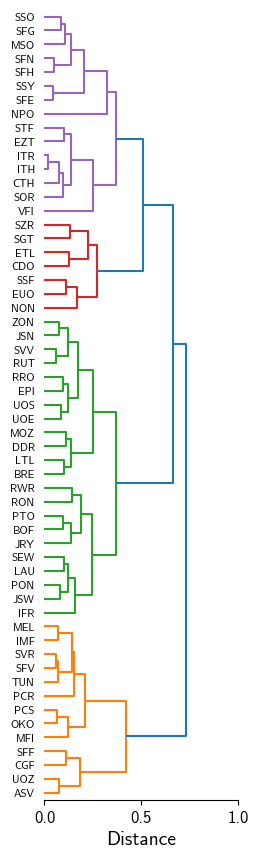

In [9]:
for i in np.unique(clusters):
    idx = clusters == i
    if idx.sum() <= 1:
        continue
        
    _dm = dm.loc[idx]
    _dm = _dm[_dm.index]
    _labels = _dm.columns
    _z = linkage(squareform(_dm.values), method='ward')
    
    fig, ax = plt.subplots(figsize=(2.5, 0.18 * len(_dm)))
    
    dendrogram(
        _z,
        leaf_rotation=0.,
        leaf_font_size=8.,
        color_threshold=0.5,
        orientation="right"
    )

    yticks = [int(t.get_text()) for t in ax.get_yticklabels()]

    ax.set_yticklabels([_labels[tick] for tick in yticks])
    ax.set_xlabel('Distance')
    ax.set_xlim(0, 1.0)
    ax.spines["left"].set_visible(False)

    # fig.savefig("dendrogram.pdf", bbox_inches="tight")
    plt.show()

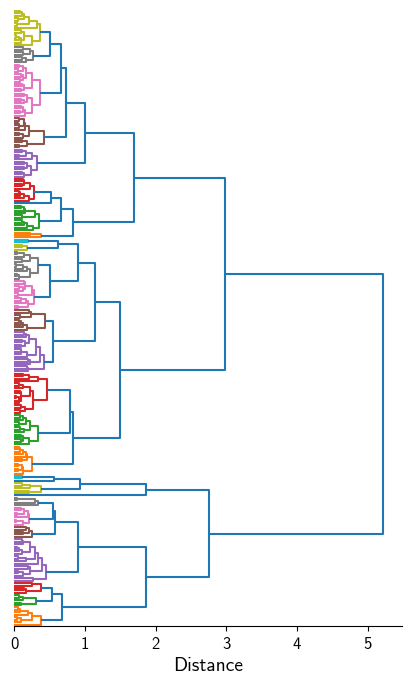

In [10]:
fig, ax = plt.subplots(figsize=(5, 8))

_labels = dm.columns
dendrogram(
    Z,
    leaf_rotation=0.,
    leaf_font_size=8.,
    color_threshold=0.5,
    orientation="right"
)

ax.set_yticks([])
ax.set_xlabel('Distance')
ax.spines["left"].set_visible(False)

plt.show()